In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.set(rc={'figure.figsize':(14, 10)})

In [2]:
p_match = pd.read_csv('https://raw.githubusercontent.com/weichseltree/euro2020/main/p_match.csv')
p_match.head(5)

,country_1,country_2,p_knockout_win,p_normal_time_win,p_normal_time_draw,p_normal_time_loss
0,Hungary,North Macedonia,0.543,0.390,0.295,0.315
1,Hungary,Finland,0.552,0.396,0.299,0.305
2,Hungary,Slovakia,0.416,0.278,0.298,0.424
3,Hungary,Ukraine,0.478,0.339,0.284,0.377
4,Hungary,Czech Republic,0.443,0.301,0.297,0.402


In [3]:
from jax import grad
import jax.numpy as jnp
from jax import jit
from jax import vmap
from jax import random

In [4]:
goals = np.arange(10)
factorials = np.array([np.math.factorial(goal) for goal in goals])

def double_poisson_regression(country_1, country_2, country_1_2):
    lambda_1 = jnp.expand_dims(country_1 + country_1_2, axis=-1)
    lambda_2 = jnp.expand_dims(country_2 - country_1_2, axis=-1)

    poisson_1 = lambda_1**goals*jnp.exp(-lambda_1)/factorials
    poisson_2 = lambda_2**goals*jnp.exp(-lambda_2)/factorials
    return poisson_1, poisson_2

def to_poisson_matrix(poisson_1, poisson_2):
    poisson_matrix = jnp.dot(jnp.expand_dims(poisson_1, axis=1), jnp.expand_dims(poisson_2, axis=0))
    poisson_matrix /= jnp.sum(poisson_matrix)
    return poisson_matrix

ones_like_matrix = np.ones(shape=(10, 10))
win_mask = np.tril(ones_like_matrix, k=-1)
draw_mask = np.eye(ones_like_matrix.shape[0])
loss_mask = np.triu(ones_like_matrix, k=1)

def p_normal_time(poisson_matrix):
    p_normal_time_win = jnp.sum(poisson_matrix*win_mask)
    p_normal_time_draw = jnp.sum(poisson_matrix*draw_mask)
    p_normal_time_loss = jnp.sum(poisson_matrix*loss_mask)

    return p_normal_time_win, p_normal_time_draw, p_normal_time_loss

In [5]:
poisson_1, poisson_2 = double_poisson_regression(0.3, 4.5, 0)
poisson_matrix = to_poisson_matrix(poisson_1, poisson_2)
p_normal_time_win, p_normal_time_draw, p_normal_time_loss = p_normal_time(poisson_matrix)

In [6]:
def plot_matix(matrix, annot=True):
    ax = sns.heatmap(matrix, annot=annot)
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.xlabel("country 2")
    plt.ylabel("country 1")
    plt.show()

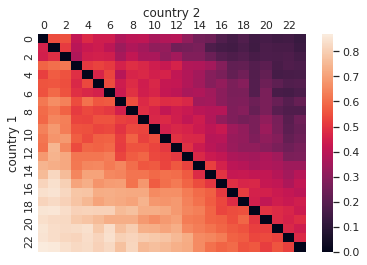

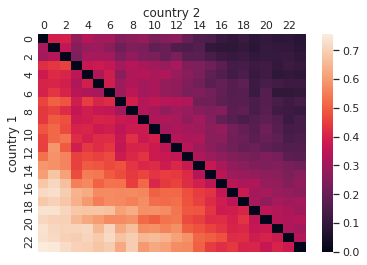

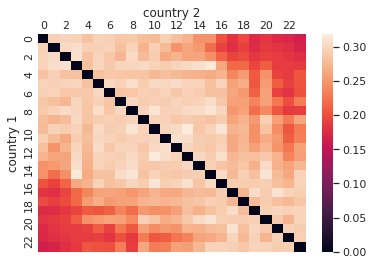

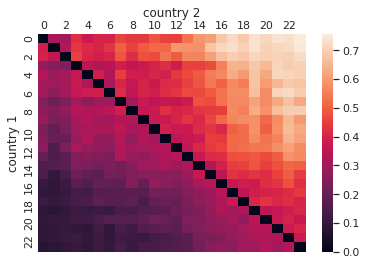

In [7]:
p_knockout_win_matrix = np.zeros(shape=(24, 24))
p_normal_time_win_matrix = np.zeros(shape=(24, 24))
p_normal_time_draw_matrix = np.zeros(shape=(24, 24))
p_normal_time_loss_matrix = np.zeros(shape=(24, 24))

country_id = {country: id for id, country in enumerate(p_match.country_1.unique())}
for index, row in p_match.iterrows():
    c_1, c_2 = country_id[row['country_1']], country_id[row['country_2']]
    p_knockout_win_matrix[c_1, c_2] = row['p_knockout_win']
    p_normal_time_win_matrix[c_1, c_2] = row['p_normal_time_win']
    p_normal_time_draw_matrix[c_1, c_2] = row['p_normal_time_draw']
    p_normal_time_loss_matrix[c_1, c_2] = row['p_normal_time_loss']

plot_matix(p_knockout_win_matrix, annot=False)
plot_matix(p_normal_time_win_matrix, annot=False)
plot_matix(p_normal_time_draw_matrix, annot=False)
plot_matix(p_normal_time_loss_matrix, annot=False)

Manua(e)l fitting

In [205]:
for index, row in p_match.iterrows():
    if (row['country_1'] == 'Wales'   and row['country_2'] == 'Switzerland') \
    or (row['country_1'] == 'Denmark' and row['country_2'] == 'Finland') \
    or (row['country_1'] == 'Belgium' and row['country_2'] == 'Russia'):
        c_1, c_2 = country_id[row['country_1']], country_id[row['country_2']]
        print(row['country_1'], c_1, row['country_2'], c_2)
        print(row['p_normal_time_win'], row['p_normal_time_draw'], row['p_normal_time_loss'])


Wales 8 Switzerland 13
0.287 0.302 0.41200000000000003
Denmark 15 Finland 2
0.611 0.244 0.145
Belgium 18 Russia 6
0.575 0.251 0.17300000000000001


In [30]:
def single_prediction(lambda_1, lambda_2):
    poisson_1, poisson_2 = double_poisson_regression(lambda_1, lambda_2, 0)
    poisson_matrix = to_poisson_matrix(poisson_1, poisson_2)
    p_normal_time_win, p_normal_time_draw, p_normal_time_loss = p_normal_time(poisson_matrix)
    return p_normal_time_win, p_normal_time_draw, p_normal_time_loss

def cross_entropy_loss(prediction, target):
    return -jnp.mean(jnp.stack(target, axis=-1)*jnp.log(jnp.stack(prediction, axis=-1)), axis=-1)

In [31]:
def get_loss_for_single_prediction(lambda_1, lambda_2):
    return cross_entropy_loss(single_prediction(lambda_1, lambda_2), (0.611, 0.244, 0.145))

grad_lambda_1 = grad(get_loss_for_single_prediction, argnums=0)
grad_lambda_2 = grad(get_loss_for_single_prediction, argnums=1)

lambda_1 = 1.0
lambda_2 = 1.0

In [32]:
for _ in range(1000):
    #print(lambda_1, lambda_2)
    #print(*single_prediction(lambda_1, lambda_2))

    grad_1 = -grad_lambda_1(lambda_1, lambda_2)
    grad_2 = -grad_lambda_2(lambda_1, lambda_2)

    #print(grad_1, grad_2)

    lambda_1 += grad_1
    lambda_2 += grad_2

print(lambda_1, lambda_2)

1.6206625 0.6419102


(DeviceArray(0.6109999, dtype=float32), DeviceArray(0.24400039, dtype=float32), DeviceArray(0.14499989, dtype=float32))


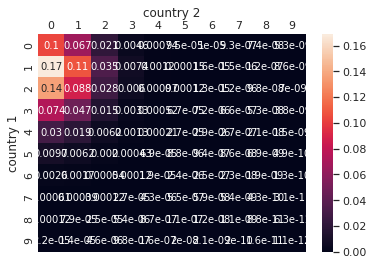

In [33]:
poisson_1, poisson_2 = double_poisson_regression(lambda_1, lambda_2, 0)
poisson_matrix = to_poisson_matrix(poisson_1, poisson_2)
print(p_normal_time(poisson_matrix))

ax = sns.heatmap(poisson_matrix, annot=True)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.tick_params(length=0)
plt.xlabel("country 2")
plt.ylabel("country 1")
plt.show()